[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we compare 2 optimization techniques: The "classical" **Adam** and a new extension of the same optimizer called **gradient centralization**. More info:

(Extracted from https://arxiv.org/abs/2004.01461)

*Optimization techniques are of great importance to effectively and efficiently train a deep neural network (DNN). It has been shown that using the first and second order statistics (e.g., mean and variance) to perform Z-score standardization on network activations or weight vectors, such as batch normalization (BN) and weight standardization (WS), can improve the training performance. Different from these existing methods that mostly operate on activations or weights, we present a new optimization technique, namely gradient centralization (GC), which operates directly on gradients by centralizing the gradient vectors to have zero mean. GC can be viewed as a projected gradient descent method with a constrained loss function. We show that GC can regularize both the weight space and output feature space so that it can boost the generalization performance of DNNs. Moreover, GC improves the Lipschitzness of the loss function and its gradient so that the training process becomes more efficient and stable. GC is very simple to implement and can be easily embedded into existing gradient based DNN optimizers with only one line of code. It can also be directly used to fine-tune the pre-trained DNNs. Our experiments on various applications, including general image classification, fine-grained image classification, detection and segmentation, demonstrate that GC can consistently improve the performance of DNN learning. The code of GC can be found at this https URL.*

#### Library Imports

In [1]:
!pip install -q tf-models-official
!pip install opencv-python-headless==4.1.2.30

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import csv
import gc
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from tensorflow.keras.applications import mobilenet_v3
import tensorflow.keras.backend as K

from official.vision.image_classification.augment import RandAugment

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

#### Auxiliar functions
Check the docstrings for more information.

In [3]:
class GCAdam(optimizers.Adam):
    """
    Class extending classical Adam algorithm in order to
    include gradient centralization.
    """
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

In [85]:
# Function for plotting images.
def plot_samples(dataset):
    sample_images, sample_labels = next(iter(dataset))
  
    plt.figure(figsize=(3, 3))
    for ix, sample_image in enumerate(sample_images[:9]):
        plt.subplot(3, 3, ix+1)
        plt.imshow(sample_image.numpy().astype(np.uint8))
        plt.axis("off")
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

def read_data(path_list, im_size=(224,224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2] 
                im = cv2.imread(im_file, cv2.IMREAD_COLOR) 
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                #im = quantize_image(im)
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                continue
    
    X = np.array(X) # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    
    return X, y

# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks():
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [    
        # If val_loss doesn't improve for a number of epochs set with 'patience' var 
        # training will stop to avoid overfitting.     
        callbacks.ModelCheckpoint(
            filepath=WEIGHTS_FILE,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        ]

#### Experimental Constants

In [86]:
INPUT_SHAPE = (224, 224, 3)
IM_SIZE = (224, 224)
NUM_EXPERIMENTS = 10
NUM_EPOCHS = 30
BATCH_SIZE = 12
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2
RANDOM_STATE = 2022
WEIGHTS_FILE = "weights.h5"# File that stores updated weights
AUTO = tf.data.AUTOTUNE
# Datasets' paths we want to work on.
PATH_LIST = ["eden_library_datasets/Orange tree-060521-K deficiency-zz-V1-20210721140920",
             "eden_library_datasets/Orange tree-060521-Mg deficiency-zz-V1-20210721140926",
            ]

tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#### Loading images and Data Loaders

In [87]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
X, y = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 45/45 [00:05<00:00,  7.88it/s]


#### Function for creating the architecture

In [88]:
def get_architecture(y, mobilenet_size, learning_rate, use_gradient_centralization=False):
    """
    Given the parameters, it returns a compiled architecture (MobileNetV3)
    ready for training.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    #input_aug = img_augmentation(inputs)
    input_norm = layers.Lambda(mobilenet_v3.preprocess_input)(inputs) # placeholder in this case

    if mobilenet_size == "small":
        feature_extractor = MobileNetV3Small(
            weights="imagenet",
            include_top=False,
            input_tensor=input_norm)
    elif mobilenet_size == "large":
        feature_extractor = MobileNetV3Large(
            weights="imagenet",
            include_top=False,
            input_tensor=input_norm)
        
    feature_extractor.trainable = True

    # Create new model on top.
    feataures = layers.GlobalAveragePooling2D(name="pool")(feature_extractor.output) # Flattening layer.  
    fully = layers.Dense(units=64, activation="relu")(feataures) # Add a fully connected layer.
    # Create a Classifier with shape=number_of_training_classes.
    fully = layers.Dropout(0.3)(fully) # Regularize with dropout.
    out = layers.Dense(units=y.shape[1], 
                       activation="softmax")(fully)
    # This is the final model.            
    model = Model(inputs, out)

    if use_gradient_centralization:
        optimizer = GCAdam(learning_rate=learning_rate)
    else:
        optimizer = optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    #model.summary()
    return model

#### Object for creating augmenations

In [89]:
augmenter = RandAugment(num_layers=1, magnitude=3)

#### Function for creating TF datasets from Numpy Arrays

In [90]:
def get_datasets(X, y):
    """
    Given numpy arrays for images and labels it returns 
    TF datasets for training, validation and testing.
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=TEST_SPLIT,
                                                        shuffle = True,
                                                        stratify = y,
                                                        random_state = RANDOM_STATE)

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=VAL_SPLIT, 
                                                      shuffle = True,
                                                      stratify = y_train,
                                                      random_state = RANDOM_STATE)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

    clean_train_ds = (
        train_ds.shuffle(BATCH_SIZE, seed=RANDOM_STATE)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    noisy_train_ds = (
        train_ds.shuffle(BATCH_SIZE, seed=RANDOM_STATE)
        .map(lambda x, y: (augmenter.distort(x), y), num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    val_ds = (
        val_ds.batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    test_ds = (
        test_ds.batch(BATCH_SIZE)
        .prefetch(AUTO)
    )

    return clean_train_ds, noisy_train_ds, val_ds, test_ds

#### Creating Datasets

In [91]:
clean_train_ds, noisy_train_ds, val_ds, test_ds = get_datasets(X, y)

#### Plotting some samples

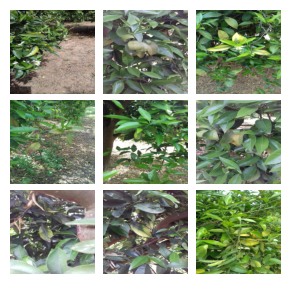

In [92]:
plot_samples(clean_train_ds)

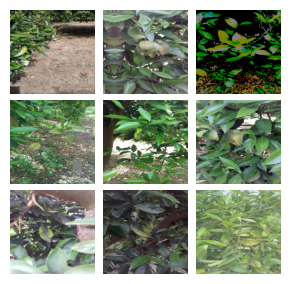

In [93]:
plot_samples(noisy_train_ds)

#### Training WITHOUT Gradient Centralization

In [94]:
%%time
nogc_accs = []
for i in range(NUM_EXPERIMENTS):
    print(f"Iteration: {i}")
    clean_train_ds, noisy_train_ds, val_ds, test_ds = get_datasets(X, y)
    model = get_architecture(y, 
                             mobilenet_size="small",
                             learning_rate=1e-3,
                             use_gradient_centralization=False)

    history = model.fit(noisy_train_ds, # train data
                              validation_data=val_ds, # labels
                              epochs=NUM_EPOCHS,
                              callbacks = get_callbacks(),
                              verbose=0)
    model.load_weights(WEIGHTS_FILE)
    test_acc = model.evaluate(test_ds, verbose=0)[1]
    print(f"Test Acc: {test_acc}")
    nogc_accs.append(test_acc)

Iteration: 0
Test Acc: 0.9375
Iteration: 1
Test Acc: 0.9375
Iteration: 2
Test Acc: 0.875
Iteration: 3
Test Acc: 0.875
Iteration: 4
Test Acc: 0.75
Iteration: 5
Test Acc: 0.9375
Iteration: 6
Test Acc: 0.625
Iteration: 7
Test Acc: 0.875
Iteration: 8
Test Acc: 0.8125
Iteration: 9
Test Acc: 1.0
CPU times: user 6min 19s, sys: 7.83 s, total: 6min 27s
Wall time: 4min 58s


In [95]:
print()
print("*"*50)
print(f"Test Accuracy: {round(np.mean(nogc_accs), 4)} ({round(np.std(nogc_accs), 4)})")
print("*"*50)
print()


**************************************************
Test Accuracy: 0.8625 (0.1038)
**************************************************



#### Training WITH Gradient Centralization

In [ ]:
%%time
gc_accs = []
for i in range(NUM_EXPERIMENTS):
    print(f"Iteration: {i}")
    clean_train_ds, noisy_train_ds, val_ds, test_ds = get_datasets(X, y)
    model = get_architecture(y, 
                            mobilenet_size="small",
                            learning_rate=1e-3,
                            use_gradient_centralization=True)

    history = model.fit(clean_train_ds, # train data
                              validation_data=val_ds, # labels
                              epochs=NUM_EPOCHS,
                              callbacks = get_callbacks(),
                              verbose=0)
    model.load_weights(WEIGHTS_FILE)
    test_acc = model.evaluate(test_ds, verbose=0)[1]
    print(f"Test Acc: {test_acc}")
    gc_accs.append(test_acc)

Iteration: 0
Test Acc: 0.8125
Iteration: 1
Test Acc: 0.75
Iteration: 2
Test Acc: 0.875
Iteration: 3
Test Acc: 0.75
Iteration: 4
Test Acc: 0.875
Iteration: 5
Test Acc: 0.8125
Iteration: 6
Test Acc: 0.9375
Iteration: 7
Test Acc: 0.6875
Iteration: 8
Test Acc: 0.875
Iteration: 9


In [ ]:
print()
print("*"*50)
print(f"Test Accuracy: {round(np.mean(gc_accs), 4)} ({round(np.std(gc_accs), 4)})")
print("*"*50)
print()

## Conclusions
Gradient Centralization is an optimization technique that should be taken into account when fine-tuning the different hyper-parameters with a deep learning pipeline. The results obtained in this notebook could change while modifying some hyper-parameters like the batch size or the number of epochs.

## Possible Extensions
1. Use a different pre-trained network (for instance, MobileNetV3Large).
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different epochs and batch sizes.

## Bibliography
https://keras.io/examples/vision/gradient_centralization/

https://arxiv.org/abs/2004.01461